The aim of this exercise is to write an MCMC code to estimate cosmological parameters from supernova Ia data. Supernova Ia are standard candles (or can be made so), so can be used to measure the contents of the Universe.

**Data:**

We have a dataset of measurements μ at various different redshifts z. So the data consists of pairs of values, (z_i , μ_i) ; i = 1, . . . 31, where z is the observed redshift of the supernova and μ is the distance modulus.

**Theory:**

The theoritical corves for μ as a function of z, for a model with 2 parameters: $h$ (Hubble constant, in units of 100 km/s/Mpc) and $\Omega_{m}$ (matter density parameter) is given, related with the following relations:

Distance modulus $\mu$:

\begin{equation}
    \mu(z)
    =
    25 - 5 \log_{10} h + 5 \log_{10} \left( D^{*}_{L}(z) \right)
\end{equation}

where $D^{*}_{L}(z)$ is:

\begin{equation}
    D^{*}_{L}(z)
    =
    3000 (1+z) \left[ \eta (1,\Omega_{m}) - \eta \left( \frac{1}{1+z}, \Omega_{m} \right) \right]
\end{equation}

\begin{equation}
    \eta(a,\Omega_{m})
    =
    2
    \sqrt{s^{3} + 1}
    \left[
        \frac{1}{a^{4}}
        -
        0.1540 \frac{s}{a^{3}}
        +
        0.4304 \frac{s^{2}}{a^{2}}
        +
        0.19097 \frac{s^{3}}{a}
        +
        0.066941 s^{4}
    \right]^{-\frac{1}{8}}
\end{equation}

\begin{equation}
    s^{3}
    =
    \frac{1-\Omega_{m}}{\Omega_{m}}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
import math as math
import pandas as pd

In [2]:
# link to the raw file for the dataset from my github
url_1 = 'https://raw.githubusercontent.com/nyctophile-aayu/Astronomical-Data-Analysis/main/jla_mub.csv'

data = pd.read_csv(url_1,encoding='utf-8')
data.columns = ["z","mu"]
print(data.head()) #displaying the first 5 rows

       z         mu
0  0.010  32.953887
1  0.012  33.879003
2  0.014  33.842141
3  0.016  34.118567
4  0.019  34.593446


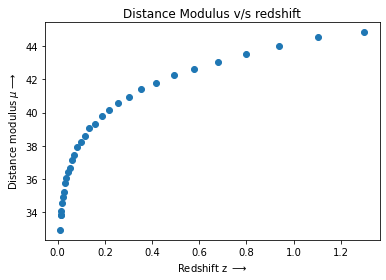

In [3]:
# Define redshift (z) and distance modulus (mu) arrays
z = np.array(data.z)                           # z values from jla_mub file
mu = np.array(data.mu)                         # mu values from jla_mub file

# Plot the data for 31 supernova
plt.plot(z, mu, 'o')                                      # plot between z and mu
plt.xlabel('Redshift z $\longrightarrow$')                # x label
plt.ylabel('Distance modulus $\mu \longrightarrow$')      # y label
plt.title('Distance Modulus v/s redshift')                # plot title
plt.show()

In [4]:
# Defining number of parameter and sample values
nsamples = 10000
npars = 2

# Define (Gaussian) width of the proposal distribution
sigma_Omega_m = 0.01
sigma_h = 0.01

# For very small proposal distribution:
# sigma = [0.001,0.001]

# For large proposal distribution:
# sigma = [0.1,1]

# Number of bins of supernova data
nSN = 31

# Temporary variable to store mu(observation)- mu(theory)
Dmu = np.empty(nSN)

# Define an empty array of parameter values for each point of previous two
# parameters Omega_m and h
# Create a [10000,3] empty array
mcmc_arr = np.empty([nsamples, npars+1])

# Generate a random uniform number for likelihood calculation 
mcmc_arr[0,:] = [np.random.uniform(), np.random.uniform(), -1.e100]

# Define z grid, Omega_m and h values
npts = 300
z_plot = np.linspace(0.01, 1.3, npts)
mu_plot = np.empty(npts)

In [5]:
from google.colab import files
uploaded = files.upload()

Saving jla_mub_covmatrix.txt to jla_mub_covmatrix (3).txt


In [6]:
# Read in the covariance matrix (as a list), reshape it to 31 x 31, then invert it
f = open('jla_mub_covmatrix.txt','r')
cov = np.loadtxt(f)
cov = np.reshape(cov,(nSN,nSN))
f.close()

InvC = np.empty([nSN,nSN])
InvC = np.linalg.inv(cov)

In [7]:
# First defining eta as a function of a and Omega_m, and defining s:
def eta(a, Omega_m):
    if (Omega_m>=0.9999):
        Omega_m= 0.9999
    else:
        pass
    s3 = (1.0 - Omega_m)/Omega_m
    s = np.power(s3, 1.0/3.0)
    s2 = s*s
    s4 = s2*s2

    x = 1.0/(a**4) - 0.1540 * (s/a**3) + 0.4304*(s2/a**2) + 0.19097 * (s3/a) + 0.066941 * s4
    eta = 2.0*np.sqrt(s3 + 1.0) * np.power(x,-1.0/8.0)
    return eta

# Now, defining Luminosity Distance, DL as a function of z and Omega_m:
# Valid for flat Universe only (Omega = 1)
def DLstar(z, Omega_m):
    # Speed of light(c) is 3.e8 in m/s and 3.e5 in km/s 
    # and we divide it by Hubble constant(H0) = 100h km/s/Mpc
    DLstar = 3000.0*(1.0+z)*(eta(1.0,Omega_m) - eta(1.0/(1.0+z), Omega_m))
    return DLstar

# =============================================================================

# Function to calculate luminosity distance in terms of integral function
# For non-flat Universe (Omega > 1), uncomment below section and comment above section for DLstar
# def Dl(z,Omega_m,h):
#     #The integration part in the formula for Dl
#     def integrand(x):
#         integral= 1/(np.sqrt(Omega_m*((1+x)**3)+(Omega-Omega_m)+(1-Omega)*((1+x)**2)))
#         return integral
#     x_arr = np.linspace(0,z,num = 500, endpoint = True)
#     # answer,err = quad(integrand, 0, z) 
#     # Speed of light(c) is 3.e8 in m/s and 3.e5 in km/s 
#     # and we divide it by Hubble constant(H0) = 100h km/s/Mpc
#     y_arr = integrand(x_arr)
#     answer = simps(y_arr,x_arr)
#     DLstar = 3000*(1/h)*(1+z)*answer
#     return DLstar

# Define distance modulus(model) as a function of z, Omega_m, and h(for non-flat Universe):
# def mu_m(z, Omega_m, h):
#     #"Distance modulus at redshift z, for flat Universe with parameters Omega_m, h"
#     mu = 25.0 - 5.0*math.log10(h) + 5.0*math.log10(DLstar(z, Omega_m, h))
#     return mu

# =============================================================================

# And, then defining distance modulus(model) as a function of z, h amd Omega_m(for flat Universe):
def mu_m(z, Omega_m, h):
    mu = 25.0 - 5.0 * np.log10(h) + 5.0 * np.log10(DLstar(z, Omega_m))
    return mu

# Random starting point in parameter space; each parameter in range (0,1)
# Define Likelihood function
def lnL(Omega_m, h):

# Set initial likelihood to low value so next point is accepted
    if(Omega_m<=0.0 or h<=0.0):
        lnL = -1.e100
    else:

# Now, deduce difference between mu(theory) and mu(observation)
# mu is the array loaded from the observation in the very initial part of the code
        for i in range(nSN):
            Dmu[i] = mu[i]- mu_m(z[i],Omega_m,h)

# Now, at last computing likelihood
        lnL = -0.5*np.dot(Dmu,np.dot(InvC,Dmu))
    return lnL

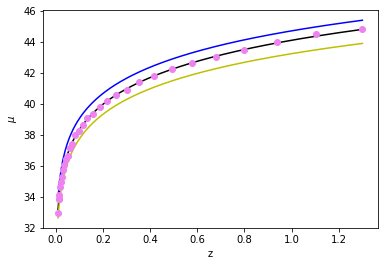

In [9]:
# Plot a few theoritical curves on top of the data
for i in range(npts):
  mu_plot[i] = mu_m(z_plot[i], 0.3, 0.7)
plt.plot(z_plot, mu_plot, color = 'k')
plt.xlabel('z')
plt.ylabel(r'$\mu$')

for i in range(npts):
  mu_plot[i] = mu_m(z_plot[i], 0.4, 0.5)
plt.plot(z_plot, mu_plot, color = 'b')

for i in range(npts):
  mu_plot[i] = mu_m(z_plot[i], 0.6, 0.9)
plt.plot(z_plot, mu_plot, color = 'y')

# Plot the data
plt.plot(z, mu, 'o', color = 'violet')
plt.show()

In [10]:
# Calculate an initial likelihood value and store it as the third column
mcmc_arr[0, npars] = lnL(mcmc_arr[0,0], mcmc_arr[0,1])

# Draw new proposed samples from a proposal distribution, centered on old values Omega_m[i-1], h[i-1]
# Accept or reject, and colour points according to lnL(likelihood)
for i in range(1,nsamples):
    lnL_prev = mcmc_arr[i-1,npars]

# For Gaussian proposal distribution, uncomment the below line
    # Omega_m_next = np.random.normal(mcmc_arr[i-1,0],sigma_Omega_m)
    # h_next = np.random.normal(mcmc_arr[i-1,1],sigma_h)

# Define 'top-hat' proposal distribution for Omega_m and h
# Comment the line below, to check the Gaussian distribution
    Omega_m_next = mcmc_arr[i-1,0] + np.random.uniform(-0.05,0.05)
    h_next = mcmc_arr[i-1,1] + np.random.uniform(-0.05,0.05)

    lnL_next = lnL(Omega_m_next,h_next)

# Define the Metropolis-Hastings algorithm to accept or reject the newly calculated point
# Accept the point if likelyhood has increased
    if(lnL_next > lnL_prev):
        mcmc_arr[i,0] = Omega_m_next
        mcmc_arr[i,1] = h_next
        mcmc_arr[i,npars] = lnL_next
        print("Accepted with a higher likelihood")

    else:
        y = np.random.uniform()

# Otherwise, it is accepted with a lesser likelyhood defined by a threshold
# This is generated randomly everytime.
# To select a different threshold, select a value y = np.random.uniform() and then take log(y)
        if(lnL_next - lnL_prev > np.log(y)):
            mcmc_arr[i,0] = Omega_m_next
            mcmc_arr[i,1] = h_next
            mcmc_arr[i,npars] = lnL_next
            print("Accepted with a lesser likelihood")

# Or, repeat the previous point in the chain to check if the draw is rejected. 
        else:
            mcmc_arr[i,0] = mcmc_arr[i-1,0]
            mcmc_arr[i,1] = mcmc_arr[i-1,1]
            mcmc_arr[i,2] = lnL_prev
            print("This draw is rejected")
    
# For value calculation, we reject the initial values given by the algorithm so
# as to only select the values, where the algorithm converges.
# Lets say we reject the initial 20% of the values.
reject = math.floor(nsamples/20)




print ('\n\n\nEstimated value of Omega_m = ' + str(np.mean(mcmc_arr[reject:nsamples,0])))
print ('Estimated value of h = ' + str(np.mean(mcmc_arr[reject:nsamples,1])))
print ('Estimated value of standard deviation of Omega_m = ' + str(np.std(mcmc_arr[reject:nsamples,0])))
print ('Estimated value of standard deviation of  h = ' + str(np.std(mcmc_arr[reject:nsamples,1])))

Streaming output truncated to the last 5000 lines.
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
Accepted with a lesser likelihood
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is 

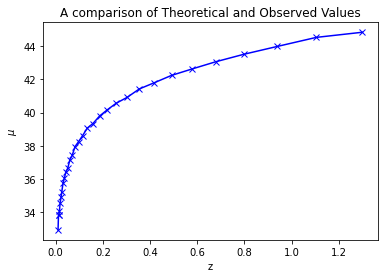

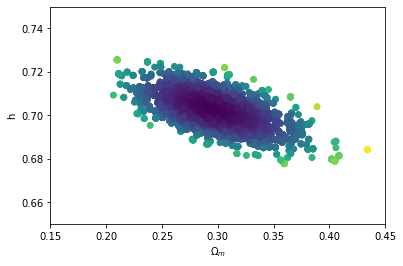

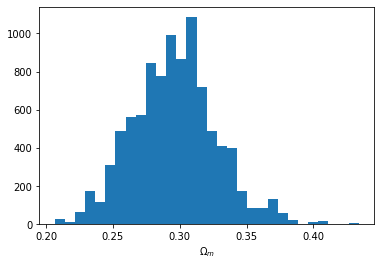

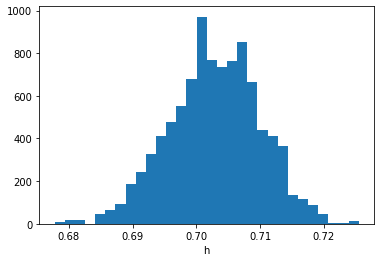

In [11]:
# Plot the samples
fig = plt.figure()

# Plot the z vs mu function for theoretical and observed values
plt.plot(z, mu, c ='blue', marker ='x', label = "Observed Data")
plt.title("A comparison of Theoretical and Observed Values")
plt.xlabel("z")
plt.ylabel(r'$\mu$')
plt.show()

# Scatter Plot MCMC Omega_m and h distribution of the sample values
plt.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1], c = -mcmc_arr[reject:,npars])
plt.xlim(0.15,0.45)
plt.ylim(0.65,0.75)
plt.xlabel(r'$\Omega_m$')
plt.ylabel('h')
plt.show()

# Histogram of Omega_m
plt.hist(mcmc_arr[reject:,0], bins = 30)
plt.xlabel(r'$\Omega_m$')
plt.show()

# Histogram of h
plt.hist(mcmc_arr[reject:,1], bins = 30)
plt.xlabel('h')
plt.show()

#Solution to the questions from the MCMC code problem.

Estimated value of Omega_m = 0.29623672058060374

Estimated value of h = 0.7029042976078089

Estimated value of standard deviation of Omega_m = 0.03139400804172487

Estimated value of standard deviation of  h = 0.007151248146685512

********************************************************************

The plot that is attached is also obtained using the same method.

When using a higher value of the proposal distribution, most of the points are rejected and only a very few are accepted.

When using a lower value of the proposal distribution, most of the points are accepted and very few are rejected.